In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics.scorer import make_scorer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.linear_model import Lasso

from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msno

import sys
sys.path.append('..')
from utils import preprocess, missing, evaluate

### Global Variables and Load Data

In [2]:
target = 'SI.POV.DDAY'
predict_year=2010
#percent of input Indicators to use (set to 100 for full set of input features)
percent = 50

In [3]:
#Load the data from disk
input_dir = '.\\..\\data\\'
data_input = "cleaned_data.pkl"
data = pd.read_pickle(input_dir + data_input)

#Possible subset of data choosen to reduce calulation time
#For percetages less than 100% we try to choose a subset that represents the spread of variables

if percent == 100:
    pass
else: 
    num_indicators_original = data.shape[1]
    step = int(100/percent)
    data_new = data.iloc[:,::step].copy()
    #Add the target column if not already included
    if target not in data_new.columns:
        data_new[target] = data[target]
    data = data_new
    
print(data.shape[1], "indicators included")

411 indicators included


### Multicountry plot across the first 20 independent variables and the dependent variable (SI.POV.DDAY)

The following plot is a quick illustration of the state of data in across multiple coutries.

One thing that it clearly shows is that there is a strong correlation of location of missing values for many of the variables. However for some others, such as SI.POV.DDAY and SI.POV.GINI this is less the case. 

Secondly, it is clear that we will need a model that is robust to missing values.

A key question here is if these patterns help us know if we have to model each country seperately or if one model fits all. Is there a method that can help us to work this out? Maybe there is a middle ground of number of models (for example a different model for every continent.

There are a number of outlier countries that could be investigated as well. For example, in SE.PRM.UNER. What should be done with these? How should our respond to these outliers?

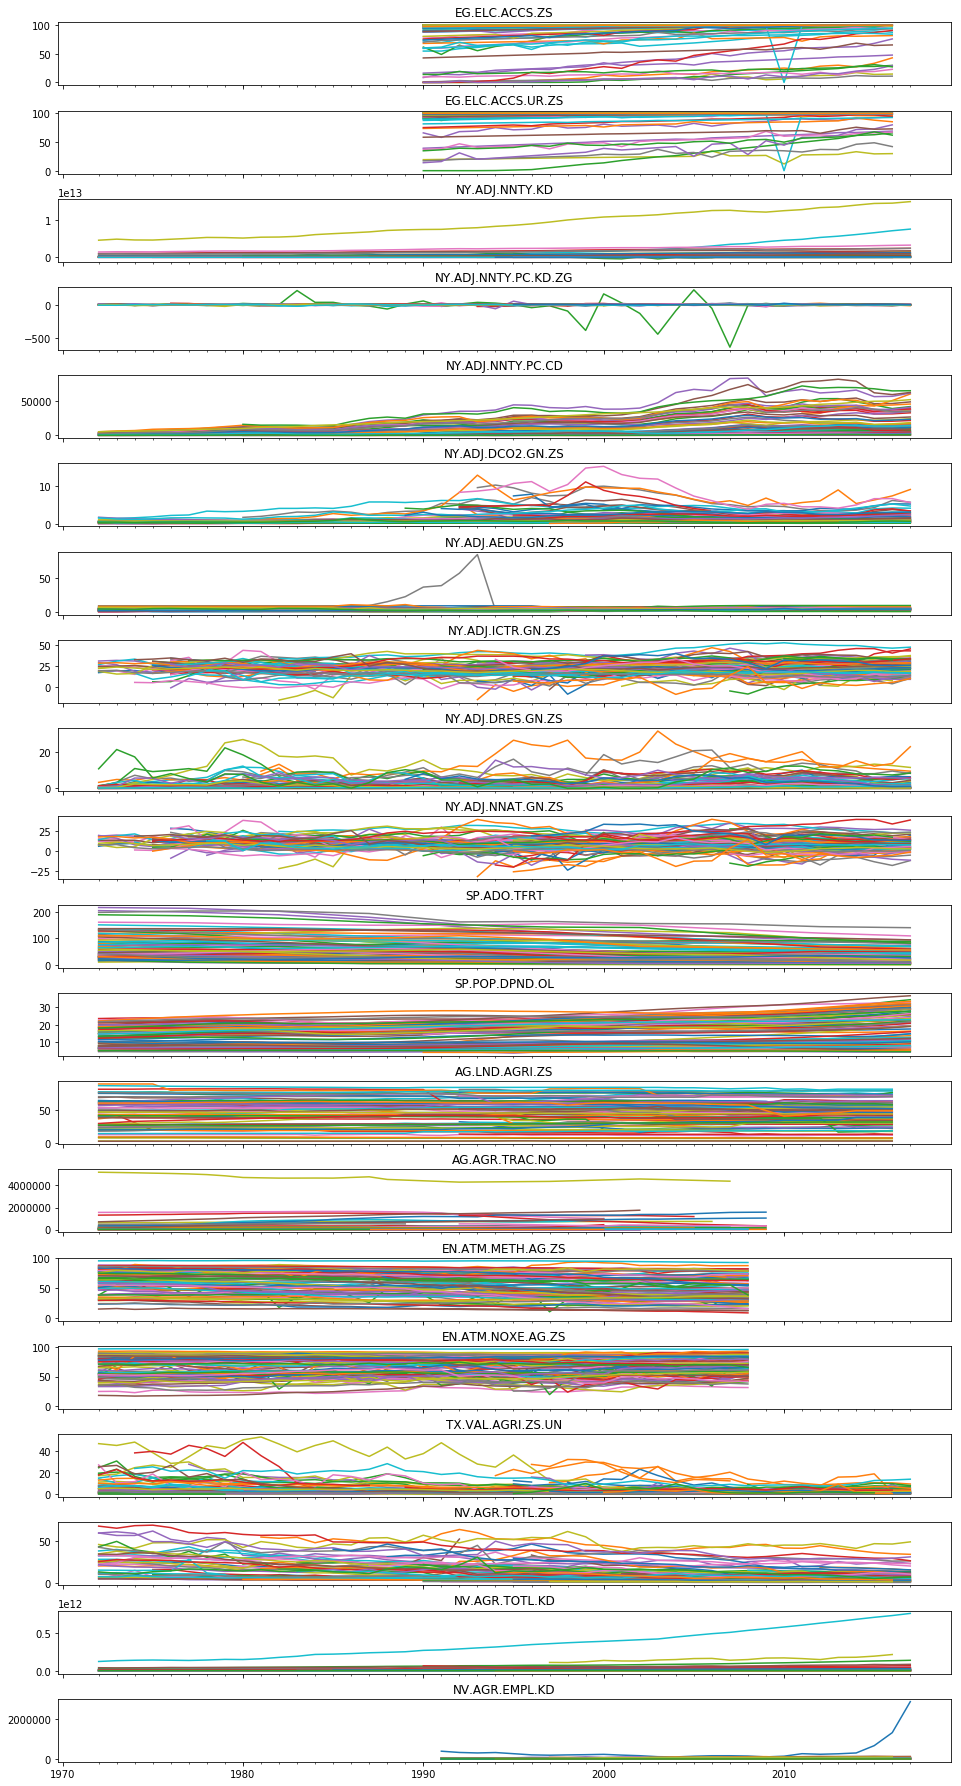

In [4]:
#Create a list of coutries to be plotted in the summary plot below
countries = list(data.index.levels[0])

#pyplot.figure(figsize=(16, 20))
inputs = list(data.iloc[:,:20].columns)

fig, axes = plt.subplots(len(inputs), 1, sharex=True ,figsize=(16, 32))

for i in range(len(inputs)):
    axes[i].set_xticks(list(range(1972,2018)), minor=True)
    axes[i].set_title(inputs[i])
    #ax.set_yticklabels([])
    column = inputs[i]
    for country in countries:
        values = data.loc[country][column].values
        axes[i].plot( list(range(1972,2019)), values)
plt.subplots_adjust(wspace=0, hspace=0.4)
#fig.invert_xaxis()
#pyplot.show()

### Break data into windows

Break up input dataframe (countries/year as 2-level index and economic indicators as columns) into windowed dataframes for training and testing.

A windowed dataframe can be seen below. Each window row is a sliding window (of size 'lag') of the indictor data.


In [5]:
%time data_regressors, data_targets = \
        preprocess.window_data(data, lag=3,num_windows=10, step=1, predict_year=2010, \
                         target=target, impute_type='interpolation')

Wall time: 3min 36s


In [6]:
#Break up into training and testing data.

idx = pd.IndexSlice
data_train_regressors = data_regressors.loc[idx[:,2:10],:]
data_train_targets = data_targets.loc[idx[:,2:10],:]
data_test_regressors = data_regressors.loc[idx[:,1],:]
data_test_targets= data_targets.loc[idx[:,1],:]

Widowed dataframe:

In [9]:
data_train_regressors.head(13)

Indicator Code   EG.ELC.ACCS.ZS                   EG.ELC.ACCS.UR.ZS           \
lag                           1        2        3                 1        2   
country   window                                                               
Argentina 2             97.1672  97.5394  97.9341           97.1672  97.5394   
          3              96.813  97.1672  97.5394            96.813  97.1672   
          4             96.4707   96.813  97.1672           96.4707   96.813   
          5             96.1342  96.4707   96.813           96.1342  96.4707   
          6             95.7975  96.1342  96.4707           95.7975  96.1342   
          7             95.5111  95.7975  96.1342           95.5111  95.7975   
          8             95.0992  95.5111  95.7975           95.0992  95.5111   
          9             94.7255  95.0992  95.5111           94.7255  95.0992   
          10            94.3288  94.7255  95.0992           94.3288  94.7255   
Armenia   2             99.2657   99.331  99.4156           99.4497  99.5109   
          3                99.8  99.2657   99.331              99.9  99.4497   
          4             99.1797     99.8  99.2657           99.3574     99.9   
          5             99.1483  99.1797     99.8           99.3213  99.3574   

Indicator Code            NY.ADJ.NNTY.KD                            \
lag                     3              1            2            3   
country   window                                                     
Argentina 2       97.9341       2.88e+11  3.22775e+11  3.42548e+11   
          3       97.5394    2.37491e+11     2.88e+11  3.22775e+11   
          4       97.1672     2.2024e+11  2.37491e+11     2.88e+11   
          5        96.813     2.2194e+11   2.2024e+11  2.37491e+11   
          6       96.4707    1.98924e+11   2.2194e+11   2.2024e+11   
          7       96.1342    2.28864e+11  1.98924e+11   2.2194e+11   
          8       95.7975    2.40891e+11  2.28864e+11  1.98924e+11   
          9       95.5111     2.4298e+11  2.40891e+11  2.28864e+11   
          10      95.0992     2.5708e+11   2.4298e+11  2.40891e+11   
Armenia   2       99.5839    7.98134e+09  9.15782e+09  9.82814e+09   
          3       99.5109      6.939e+09  7.98134e+09  9.15782e+09   
          4       99.4497    5.91136e+09    6.939e+09  7.98134e+09   
          5          99.9     5.3449e+09  5.91136e+09    6.939e+09   

Indicator Code   NY.ADJ.NNTY.PC.KD.ZG  ... NV.MNF.MTRN.ZS.UN  \
lag                                 1  ...                 3   
country   window                       ...                     
Argentina 2                   20.0003  ...           8.35139   
          3                   6.68484  ...           8.35139   
          4                  -1.84026  ...           8.35139   
          5                   10.3468  ...           8.35139   
          6                  -14.0406  ...           8.35139   
          7                  -6.04242  ...           8.35139   
          8                  -1.95473  ...           8.35139   
          9                  -6.53318  ...             8.691   
          10                  2.36229  ...           10.8172   
Armenia   2                   15.9063  ...           1.34435   
          3                   18.1462  ...           1.34167   
          4                   11.2319  ...           1.33406   
          5                   16.3484  ...           1.34271   

Indicator Code   NV.MNF.OTHR.ZS.UN                   NV.MNF.TXTL.ZS.UN  \
lag                              1        2        3                 1   
country   window                                                         
Argentina 2                38.7482  38.7482  38.7482           5.66888   
          3                38.7482  38.7482  38.7482           5.66888   
          4                38.7482  38.7482  38.7482           5.66888   
          5                38.7482  38.7482  38.7482           5.66888   
          6                38.7482  38.7482  38.7482   

### Postprocess windows

Here we deal with windows that do not have any target value. Note that in the windowed dataframe, every row is a window. Each window will act as an observation in the input to our machine learning algorithm.

In the case of the training data, we get rid of these windows (both in the regressor training dataframe and the target training dataframe).

*TODO: Investigate possibility of imputing missing target data. One lead is [here](https://www.analyticbridge.datasciencecentral.com/forum/topics/missing-values-in-target)*

In the case of the test data we also do the same, as without a target, it is impossible to evaluate the error in prediction.


In [10]:
#For Training, only consider windows that don't have a missing target as they offer nothing to training
#Therefore, remove those observations from both the training regressors and targets datasets.
data_train_regressors_subset = data_train_regressors[~np.isnan(list(data_train_targets.values.flatten()))]
data_train_targets_subset = data_train_targets[~np.isnan(list(data_train_targets.values.flatten()))]

#For testing, also remove windows with no target variable as it is impossible to measure preformance.
data_test_regressors_subset = data_test_regressors[~np.isnan(list(data_test_targets.values.flatten()))]
data_test_targets_subset = data_test_targets[~np.isnan(list(data_test_targets.values.flatten()))]


### Standardize

In [11]:
scaler = StandardScaler()
#Fit the scaler on the training data only
scaler.fit(data_train_regressors_subset)

data_train_regressors_std_array = scaler.transform(data_train_regressors_subset)
data_test_regressors_std_array = scaler.transform(data_test_regressors_subset)


C:\Users\Fergus\.conda\envs\sdgs-env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Fergus\.conda\envs\sdgs-env\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by StandardScaler.
  """
C:\Users\Fergus\.conda\envs\sdgs-env\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, object were all converted to float64 by StandardScaler.
  


In [13]:
data_train_regressors_std = pd.DataFrame(data_train_regressors_std_array, index=data_train_regressors_subset.index, columns=data_train_regressors_subset.columns)
data_test_regressors_std = pd.DataFrame(data_test_regressors_std_array, index=data_test_regressors_subset.index, columns=data_test_regressors_subset.columns)


### Linear Regression Prediction 

#### Historical values of the target only

This is very much an naive predictor. If we are limited to only historical values of the target variable then there are well established time series forecasting methods that can be used such as ARIMA. 

In [14]:
model_target_only = LinearRegression()
model_target_only.fit(data_train_regressors_std.loc[:,target],data_train_targets_subset)
#Make predictions
predictions_target_only = model_target_only.predict(data_test_regressors_std.loc[:,target])

mse_target_only = mean_squared_error(data_test_targets_subset, predictions_target_only)
print("RMSE of linear regression using historical target values only is:", np.sqrt(mse_target_only))

RMSE of linear regression using historical target values only is: 5.271521120174097


#### OLS Linear Regression

Here we use the linear regression function in scikit-learn. From an implementation point of view, this is just plain ordinary least squares (scipy.linalg.lstsq) wrapped as a scikit-learn predictor object.

In [15]:
model_linear = LinearRegression()
model_linear.fit(data_train_regressors_std,data_train_targets_subset)
#Make predictions
predictions = model_linear.predict(data_test_regressors_std) 

mse= mean_squared_error(data_test_targets, predictions)
print("RMSE of OLS linear regression using all target values only is:", np.sqrt(mse))

RMSE of OLS linear regression using all target values only is: 7.40465407559768


#### Ridge Regression

In [16]:
scorer = make_scorer(mean_squared_error)

model_ridge = RidgeCV(scoring=scorer, cv=5)
model_ridge.fit(data_train_regressors_std,data_train_targets_subset)
#Make predictions
predictions = model_ridge.predict(data_test_regressors_std) 

mse= mean_squared_error(data_test_targets, predictions)
print("RMSE of ridge regression using all target values only is:", np.sqrt(mse))

RMSE of ridge regression using all target values only is: 7.06996075611761


C:\Users\Fergus\.conda\envs\sdgs-env\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


#### Lasso Regression

The choice of Lasso for this problem is discussed in the associated blog. (see README.md for a link)

It is evaluated here using the cross-validation Scikit-learn estimator LassoCV. As well as using cross-validation testing to evaluate the fit, it also picks the best value of alpha that gives best predictive performance. 

The default values for the range of alpha and the number of values to test set by eps,n_alphas were tested to be ideal.

The cross validation technique here according to the textbooks is not appropiate for time-series in that there is data leakage as some of the training sets are from timestamps later in time that that the timestamps of the test sets. As noted below in the time-series cross validation section, this actually generalised beter accroding to our final test set.


In [17]:
model_lasso = LassoCV(cv=5, eps=1e-3, selection='random', random_state=0)
model_lasso.fit(data_train_regressors_std.values,data_train_targets_subset.values.flatten())
#Make predictions
predictions = model_lasso.predict(data_test_regressors_std) 

mse= mean_squared_error(data_test_targets.values.flatten(), predictions)
print("RMSE of lasso regression using all target values only is:", np.sqrt(mse))

RMSE of lasso regression using all target values only is: 4.045650591999181


[Text(0, 0.5, 'RMSE'), Text(0.5, 0, 'alpha value')]

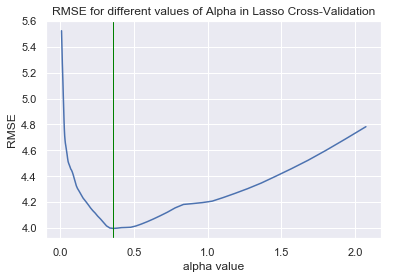

In [18]:
num_of_values_to_skip = 23 #We want to focus on the lower values of alpha for our graphs
mses = np.sqrt(np.mean(model_lasso.mse_path_[num_of_values_to_skip:], axis=1))
alphas = model_lasso.alphas_[num_of_values_to_skip:]

sns.set()
ax = sns.lineplot(alphas, mses)
ax.set_title("RMSE for different values of Alpha in Lasso Cross-Validation")

ax.axvline(alphas[np.argmin(mses)], color='green', linewidth=1)
ax.set(xlabel='alpha value', ylabel='RMSE')

In [19]:
#Convert to dataframe with country names as index
predictions_df = pd.DataFrame(predictions.flatten(), index=data_test_regressors_subset.index, columns=[target])
#Reindex in order to put back in the coutries that were removed due to lack of target.
predictions_df = predictions_df.reindex(data_test_targets.index)
(abs(predictions_df - data_test_targets)).sort_values(by='SI.POV.DDAY',ascending=False).head(10)

,,SI.POV.DDAY
country,window,
Nepal,1,17.9772
Guinea-Bissau,1,16.4171
Zambia,1,12.5557
Viet Nam,1,10.0435
Malawi,1,9.74846
Gambia,1,9.48148
Madagascar,1,6.7128
"Macedonia, Republic of",1,6.56023
South Africa,1,6.39677


The biggest errors were on countries that did not have a value measured for SI.POV.DDAY for a number of years. On the surface these could be considered outliers but instead, they are infact probably our most important coutries to predict poverty as accuractely as we can for.

IT could be a sensible approch to focus on these countries and relook at the problem at hand for them specifically. What extra features could we add to improve their performance? Is our interpolation method serving these countries well? 

#### Lars

In [20]:
from sklearn.linear_model import LassoLarsCV

In [21]:
model_lars = LassoLarsCV(cv=5, max_iter=100)
model_lars.fit(data_train_regressors_std.values,data_train_targets_subset.values.flatten())
#Make predictions
predictions = model_lars.predict(data_test_regressors_std) 

mse= mean_squared_error(data_test_targets.values.flatten(), predictions)
print("RMSE of lars regression using all target values only is:", np.sqrt(mse))

RMSE of lars regression using all target values only is: 4.283701709452111


#### ElasticNet

ElasticNet is a method that has a tuning parameter than on one extreme is identical to Lasso and at the other it's identical to Ridge.  
This brought nothing to the table as our optimal solution is 100% Lasso.

In [ ]:
model_elastic = ElasticNetCV(l1_ratio=.1,cv=5, random_state=0)
model_elastic.fit(data_train_regressors_std.values,data_train_targets_subset.values.flatten())
#Make predictions
predictions = model_elastic.predict(data_test_regressors_std) 

mse= mean_squared_error(data_test_targets.values.flatten(), predictions)
print("RMSE of ElasticNet regression using all target values only is:", np.sqrt(mse))

### Time Series Split

In [49]:
X = data_train_regressors_std.copy()
y = data_train_targets_subset.copy()

In [50]:
#We first need to sort the the rows in our test set as to have the rows in order of..
#data rather than country

#Before we do the sorting lets combine the two datasets so that we can sort both together
Xy = X
Xy.loc[:,('temp', '1')] = y.values

#Sort according to the window number
Xy = Xy.sort_index(level=1, ascending = False)

#This will be used to obtain CV splits for the following algos
tscv = TimeSeriesSplit(n_splits=5)

#Reconstruct the X and y datasets from the combined one
y = Xy.loc[:,('temp','1')].values
X = Xy.drop('temp', level=0, axis=1).values

#### Lasso with Time-series splits

Surpisingly, the time-series cross validation does not perofrm as well on the test set as the standard cross-validation used above.  
This probably warrants some more time to investigate if there is a bug somewhere in the preparation of the data.

In [54]:
model_lasso = LassoCV(cv=tscv.split(Xy), selection='random', random_state=0)
model_lasso.fit(X,y)
#Make predictions
predictions = model_lasso.predict(data_test_regressors_std) 

mse= mean_squared_error(data_test_targets.values.flatten(), predictions)
print("RMSE of time-series CV lasso regression using all target values only is:", np.sqrt(mse))

C:\Users\Fergus\.conda\envs\sdgs-env\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Fergus\.conda\envs\sdgs-env\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


RMSE of time-series CV lasso regression using all target values only is: 4.533886752086013
